# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
### Manage imports, notebook configuration and utility functions

In [33]:
# Imports
import pickle
import os
import math
import random
import urllib.request

from zipfile import ZipFile
from io import BytesIO

import numpy as np
import pandas as pd

import skimage as ski
import skimage.color
import skimage.transform
import skimage.io
import skimage.util

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import tensorflow as tf

import sklearn as skl
import sklearn.utils

# Visualizations will be shown in the notebook.
%matplotlib inline

def update_progress(progress, opt_text=""):
    """
    Print a rewritable single line ASCI progress bar.
    :param progress: Progress from 0.0 to 1.0.
    """
    bar_length = 20
    block = int(math.ceil(bar_length * progress))
    print("Progress: [{}] {:.1f}%   {:s}".format( "#" * block + "-" * (bar_length - block), progress * 100, opt_text), end='\r')


---
## Step 0: Load The Data


In [34]:
def region_of_interest(img, original_size, original_roi):
    """
    Given the original image size and region of interest (ROI), calculate the ROI according to the current shape.
    """
    return [
        original_roi[0] / original_size[0] * img.shape[0],
        original_roi[1] / original_size[1] * img.shape[1],
        original_roi[2] / original_size[0] * img.shape[0],
        original_roi[3] / original_size[1] * img.shape[1],
    ]


def load_from_pickle(file):
    """
    Load the pickled traffic sign image dataset from Udacity
    :param file: File handler to the pickle file.
    :return: A tuple of features, labels and rescaled ROIs.
    """
    data = pickle.load(file)
    X, y = data['features'], data['labels']

    assert(len(X) == len(y))

    if 'coords' in data:
        roi = np.zeros_like(data['coords'], dtype=np.float)
        for i in range(len(roi)):
            roi[i] = region_of_interest(data['features'][i], data['sizes'][i], data['coords'][i])
    else:
        roi = []

    return X, y, roi

In [35]:
# This notebook's temporary data directory
DATA_DIR = 'data'
# URL pointing to Udacity's pickled traffic signs dataset
ARCHIVE_URL = 'https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip'

# Repository locations of the downloaded and extracted data
training_file = DATA_DIR + '/train.p'
validation_file = DATA_DIR + '/valid.p'
testing_file = DATA_DIR + '/test.p'

# If the pickle files do not exist yet, download and extract the archive
if any(not os.path.exists(file) for file in (training_file, validation_file, testing_file)):
    os.makedirs(DATA_DIR)

    url = urllib.request.urlopen(ARCHIVE_URL)

    with ZipFile(BytesIO(url.read())) as my_zip_file:
        my_zip_file.extractall(DATA_DIR)

# Load training, validation and testing data
with open(training_file, mode='rb') as f:
    X_train, y_train, roi_train = load_from_pickle(f)
with open(validation_file, mode='rb') as f:
    X_valid, y_valid, roi_valid = load_from_pickle(f)
with open(testing_file, mode='rb') as f:
    X_test, y_test, roi_test = load_from_pickle(f)

print("Data successfully loaded.")

Data successfully loaded.


---
## Step 1: Dataset Summary & Exploration

### Summary and visualization of the dataset

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


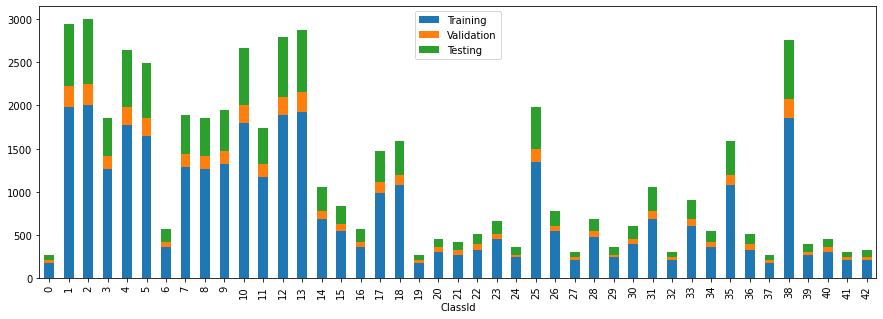

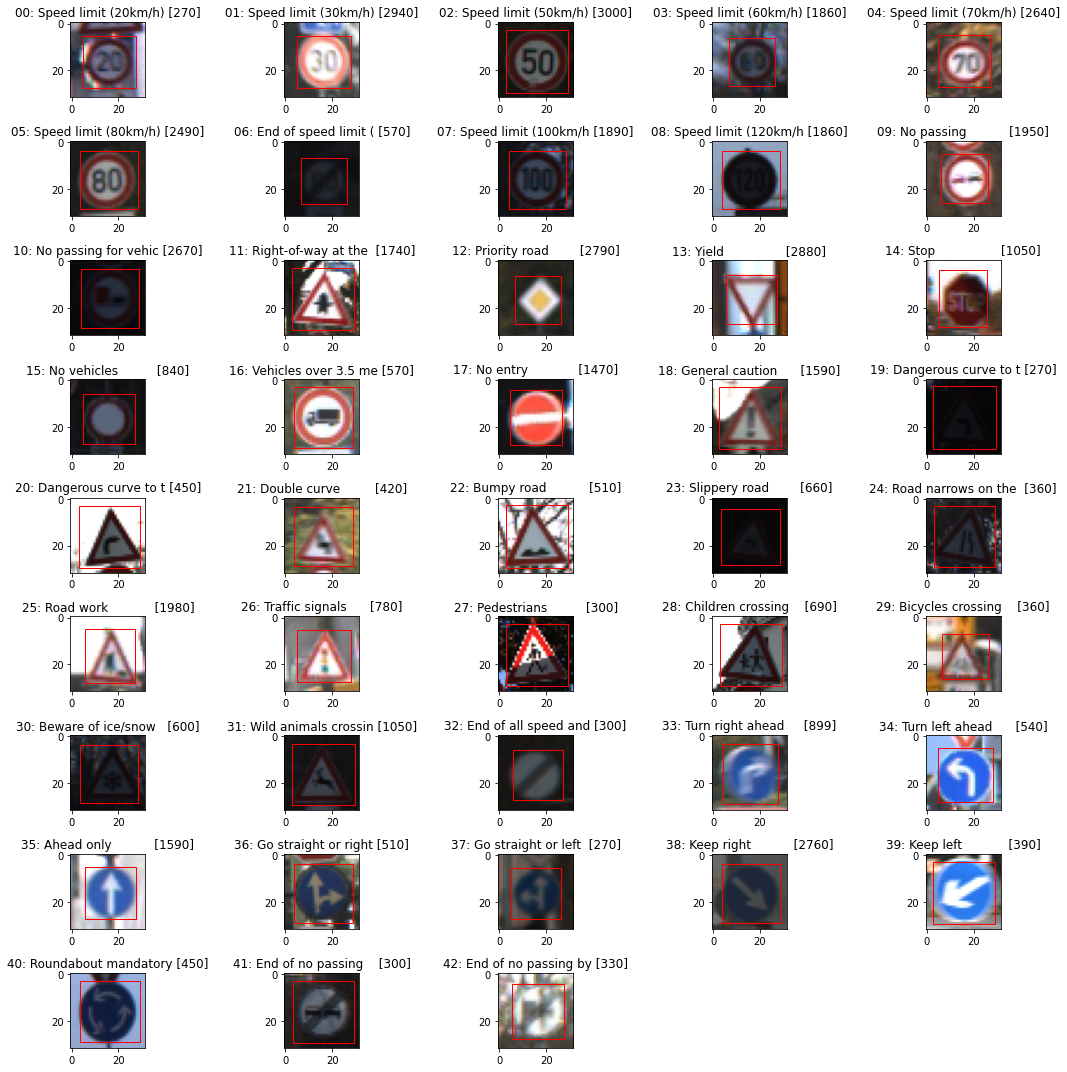

In [36]:
def summarize_dataset(train=([],[],[]), valid=([],[],[]), test=([],[],[])):
    """
    Given the loaded features, lables and ROIs for training, validation and testing data,
    print some basic metrics and visualize the dataset.
    :return: A list of class indices
    """
    (X_train, y_train, roi_train) = train
    (X_valid, y_valid, roi_valid) = valid
    (X_test, y_test, roi_test) = test

    # Assess unique classes and distribution of the training dataset using NumPy
    classes, classes_count = np.unique(y_test, return_counts=True)

    # Number of training examples
    n_train = len(y_train)
    # Number of validation examples
    n_validation = len(y_valid)
    # Number of testing examples.
    n_test = len(y_test)
    # What's the shape of an traffic sign image?
    image_shape = X_test[0].shape
    # How many unique classes/labels there are in the dataset.
    n_classes = len(classes)

    # Print basic summary
    print("Number of training examples =", n_train)
    print("Number of validation examples =", n_validation)
    print("Number of testing examples =", n_test)
    print("Image data shape =", image_shape)
    print("Number of classes =", n_classes)

    # Plot a histogram, showing the distribution of samples across classes using Pandas
    SIGNNAMES_FILE = 'signnames.csv'
    classes_df = pd.read_csv(SIGNNAMES_FILE, index_col=0)
    classes_df['Training'] = pd.Series(y_train).value_counts().sort_index()
    classes_df['Validation'] = pd.Series(y_valid).value_counts().sort_index()
    classes_df['Testing']  = pd.Series(y_test) .value_counts().sort_index()
    classes_df.plot(kind='bar', stacked=True, figsize=(15,5))
    # print(classes_df)

    # prepare a grid of subplots
    ncols = 5
    nrows = (n_classes + ncols - 1) // ncols
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15), squeeze=True)

    # iterate over all subplot axes and image classes
    for i, axi in enumerate(ax.flat):
        # i runs from 0 to (nrows*ncols-1)
        if i >= n_classes:
            fig.delaxes(axi)
            continue

        cls_id = classes[i]
        cls_title = classes_df.iloc[:,0][cls_id]
        cls_count = np.nansum([classes_df.iloc[:,k][cls_id] for k in (1,2,3)], dtype=np.uint32)

        # select an image for plotting
        indices = np.where(y_test==cls_id)[0]
        sel_index = np.random.choice(indices)
        img = X_test[sel_index]

        # plot the image along with the class index, title and number of samples per class
        axi.imshow(img)
        axi.set_title("{:02d}: {:20.20s} [{}]".format(cls_id, cls_title, cls_count))

        # draw the rectangular region of interest onto the image
        if len(roi_test) > 0:
            roi = roi_test[sel_index]
            axi.add_patch(Rectangle((roi[0],roi[1]),roi[2]-roi[0],roi[3]-roi[1],linewidth=1,edgecolor='r',facecolor='none'))

    plt.tight_layout(pad=1.08)
    plt.show()

    return classes

# print summary and plots
classes = summarize_dataset(
    (X_train, y_train, roi_train),
    (X_valid, y_valid, roi_valid),
    (X_test, y_test, roi_test)
)

# number of available classes of traffic signs
n_classes = len(classes)

----

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)

Processing image dataset ...
Progress: [####################] 100.0%   
Processing image dataset ...
Progress: [####################] 100.0%   
Processing image dataset ...
Progress: [####################] 100.0%   
Augmenting dataset ...


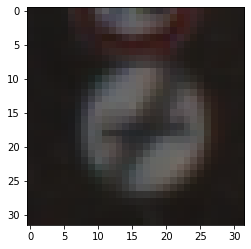

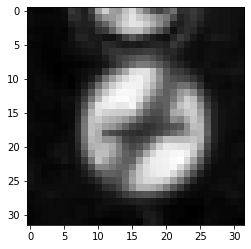

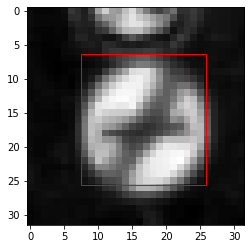

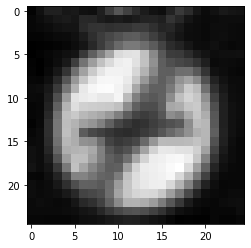

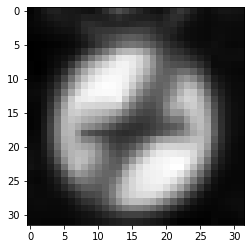

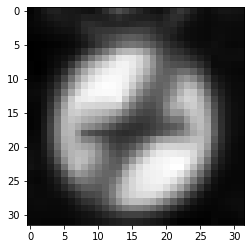

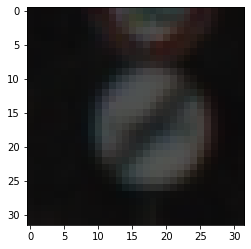

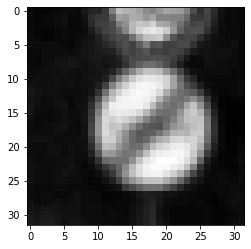

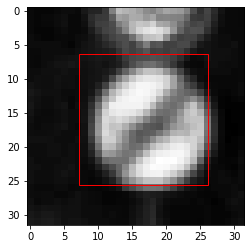

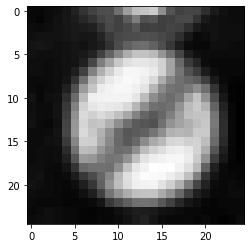

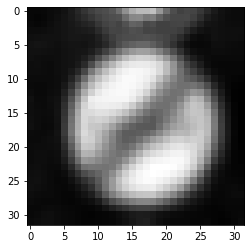

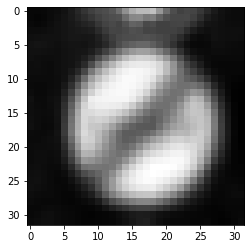

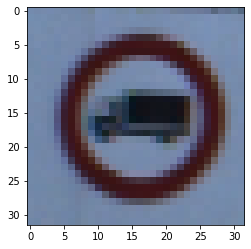

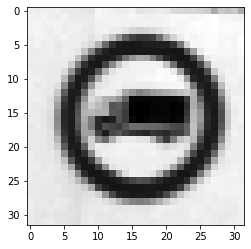

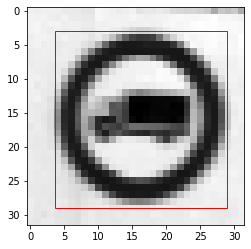

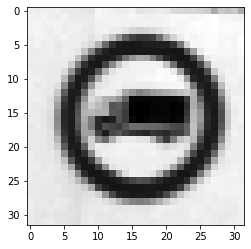

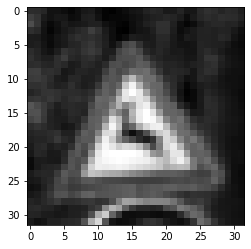

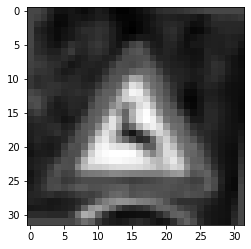

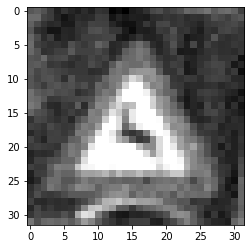

In [37]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

def pad(img, shape):
    """
    Pad the given image to fill a specific shape.
    The last pixel of the image is used for padding.
    """
    if img.shape >= shape:
        return img

    out = np.full(shape, img.flat[-1])
    out[tuple(slice(0, d) for d in np.shape(img))] = img
    return out


def preprocess_images(dataset, dataset_roi=None, size=(32,32)):
    """
    Preprocess a given image dataset.

    The following stages are executed:
    * Conversion to grayscale, if applicable.
    * If the region of interest ``dataset_roi`` is given, each image is cropped to that region, then padded and resized to match ``size``.
    * Normalization: The available color range for each image is rescaled to the range [-1.0, 1.0-]
    * The dataset is reshaped to be suitable for tensorflow input.

    :return: The processed image dataset.
    """

    print("Processing image dataset ...")
    processed_data = np.zeros((len(dataset), size[0], size[1], 1), np.float)

    for i in range(len(dataset)):

        img = dataset[i]

        if i == 0:
            plt.figure()
            plt.imshow(img)

        # Convert to grayscale
        if img.shape[-1] == 3:
            img = ski.color.rgb2gray(img)

        img = img.astype(np.float)

        if i == 0:
            plt.figure()
            plt.imshow(img, cmap="gray")

        # Crop and resize to region of interest
        if not dataset_roi is None and i < len(dataset_roi):

            roi = dataset_roi[i]

            if i == 0:
                plt.figure()
                plt.imshow(img, cmap="gray")
                plt.gca().add_patch(Rectangle((roi[0],roi[1]),roi[2]-roi[0],roi[3]-roi[1],linewidth=1,edgecolor='r',facecolor='none'))

            # Calculate a quadratic area to crop, leaving 2 pixels outside the given ROI on each side of the reactangle
            x1 = max(math.floor(roi[0])-2, 0)
            x2 = min(math.ceil(roi[2])+3, img.shape[1])
            y1 = max(math.floor(roi[1]-2), 0)
            y2 = min(math.ceil(roi[3])+3, img.shape[0])

            q = max((x2-x1), (y2-y1))
            x2 = min(x1+q, img.shape[1])
            y2 = min(y1+q, img.shape[1])

            # If the calculated crop area does differ from the current image size by 2pixels on each side, go ahead.
            if abs(size[0]-(x2-x1)) > 2 and abs(size[1]-(y2-y1)) > 2:

                # crop the image
                img_cropped = img[y1:y2,x1:x2]

                if img_cropped.size > 0:

                    if i == 0:
                        plt.figure()
                        plt.imshow(img_cropped, cmap="gray")

                    # pad the image if necessary
                    img = pad(img_cropped, (max(img_cropped.shape),max(img_cropped.shape)))

                    # print(x1,y1,x2,y2)
                    # plt.figure()
                    # plt.imshow(img, cmap="gray")

                    # resize the cropped image to match the target size again
                    img = ski.transform.resize(img, (size[0],size[1]), anti_aliasing=True)

                    if i == 0:
                        plt.figure()
                        plt.imshow(img, cmap="gray")

        # Normalize image data
        col_range = np.max(img) - np.min(img)
        img = img/col_range*2 - 1

        if i == 0:
            plt.figure()
            plt.imshow(img, cmap="gray")

        # Reshape for tensor input
        img = img.reshape((32, 32, 1))

        processed_data[i] = img

        # print progress bar
        if i % 1000 == 0 or i == len(dataset)-1:
            update_progress((i+1) / len(dataset))

    print()
    return processed_data


def augment_data(X, y, roi, size):
    """
    Augment the image dataset by picking random source images and applying random amounts of Gaussian noise and rotation of the image.
    :param size: The number of "generated" images to add to the dataset.
    """

    print("Augmenting dataset ...")

    X_augmented = np.zeros((size,) + X.shape[1:])
    y_augmented = np.zeros((size,) + y.shape[1:])
    roi_augmented = np.zeros((size,) + roi.shape[1:])

    for i in range(len(X_augmented)):

        # choose a random image from the source dataset
        p = np.random.choice(len(X))

        if i == 0:
            plt.figure()
            plt.imshow(X[p], cmap="gray")

        # apply a random amount of rotation between -15 and 15 degrees
        random_degree = random.uniform(-15, 15)
        X_augmented[i] = ski.transform.rotate(X[p], random_degree)

        if i == 0:
            plt.figure()
            plt.imshow(X_augmented[i], cmap="gray")

        # apply a random amount of gaussian noise
        random_var = random.uniform(0.0, 0.01)
        X_augmented[i] = ski.util.random_noise(X_augmented[i], var=random_var)

        if i == 0:
            plt.figure()
            plt.imshow(X_augmented[i], cmap="gray")

        # keep the label and roi for this new addition to the dataset
        y_augmented[i] = y[p]
        roi_augmented[i] = roi[p]

        # print progress
        if i % 1000 == 0 or i == len(X_augmented)-1:
            update_progress((i+1) / len(X_augmented))

    return np.concatenate((X, X_augmented)), np.concatenate((y, y_augmented)), np.concatenate((roi, roi_augmented))


def color_depth(dataset):
    """
    Determine the image color depth of a dataset.
    """
    return dataset.shape[-1] if (isinstance(dataset, np.ndarray) and dataset.ndim == 4) else 0


# Preprocess images
X_train = preprocess_images(X_train, roi_train)
X_valid = preprocess_images(X_valid, roi_valid)
X_test = preprocess_images(X_test, roi_test)

# Determine input color depth
input_depth = color_depth(X_train)

# Augment the data by 200%
X_train, y_train, roi_train = augment_data(X_train, y_train, roi_train, 2*len(X_train))

### Model Architecture

In [38]:
# Helper function around tf.nn.conv2d so simplify 2D convolutions
def conv2d(x, W, b, strides=1, padding='VALID', name=None):
    conv = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=padding, name=name)
    return tf.nn.bias_add(conv, b)


# Helper function around tf.nn.max_pool to simplify max pooling
def pool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='VALID')


def LeNet(x):
    """
    Tensor flow model for a convoluted neural network, following the LeNet-5 architecture.
    :param x: Tensor holding an array of input images with shape (32,32,1).
    :return: Tensor holding the result logits for the given input.
    """

    # Arguments used for tf.truncated_normal
    MU = 0
    SIGMA = 0.1

    # Make the convolutional layer accessible outside for visualization
    global conv1, conv2, fc2_w, fc3_w

    # Layer 1: Convolutional. Input = 32x32xinput_depth. Output = 28x28x6.
    conv1_w = tf.Variable(tf.truncated_normal([5, 5, input_depth, 6], MU, SIGMA))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = conv2d(x, conv1_w, conv1_b)
    # Activation.
    conv1 = tf.nn.tanh(conv1)
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1_p = pool2d(conv1, 2)

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_w = tf.Variable(tf.truncated_normal([5, 5, 6, 16], MU, SIGMA))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = conv2d(conv1_p, conv2_w, conv2_b)
    # Activation.
    conv2 = tf.nn.tanh(conv2)
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2_p = pool2d(conv2, 2)

    # Flatten. Input = 5x5x16. Output = 400.
    fc0 = tf.contrib.layers.flatten(conv2_p)
    # 1st Dropout.
    fc0 = tf.nn.dropout(fc0, rate=1.0-keep_prob)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_w = tf.Variable(tf.truncated_normal([400, 120], MU, SIGMA))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.add(tf.matmul(fc0, fc1_w), fc1_b)
    # Activation.
    fc1 = tf.nn.tanh(fc1)
    # 2nd Dropout.
    fc1 = tf.nn.dropout(fc1, rate=1.0-keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_w = tf.Variable(tf.truncated_normal([120, 84], MU, SIGMA))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.add(tf.matmul(fc1, fc2_w), fc2_b)
    # Activation.
    fc2 = tf.nn.tanh(fc2)
    # 3rd Dropout.
    fc2 = tf.nn.dropout(fc2, rate=1.0-keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = n_classes.
    fc3_w = tf.Variable(tf.truncated_normal([84, n_classes], MU, SIGMA))
    fc3_b = tf.Variable(tf.zeros(n_classes))
    logits = tf.add(tf.matmul(fc2, fc3_w), fc3_b)

    return logits

### Train, Validate and Test the Model

#### Hyperparameters and Operations

In [39]:
# Multiplier for L2 regularization (deactivated if 0.0)
BETA = 0.0
# Probability of keeping input nodes in dropout layers (only used during training, otherwise = 1.0)
KEEP_PROB = 0.7
# Learning rate
RATE = 0.001
# Number of epochs
EPOCHS = 500
# Batch size (lower if you run into memory issues)
BATCH_SIZE = 256


# Probability of keeping input elements to dropout nodes
keep_prob = tf.placeholder_with_default(1.0, ())
# Placeholder for input features
x = tf.placeholder(tf.float32, (None, 32, 32, input_depth))
# Placeholder for input labels (scalar)
y = tf.placeholder(tf.int32, (None))
# One hot tensor representation of labels
one_hot_y = tf.one_hot(y, n_classes)


# Logits as defined by our LeNet model
logits = LeNet(x)
# Cross Entropy (incl. Soft-Max)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
# Summation and mean
loss_operation = tf.reduce_mean(cross_entropy)

# L2 regularization (if BETA > 0)
if BETA > 0.0:
    regularizer = (tf.nn.l2_loss(fc2_w) + tf.nn.l2_loss(fc3_w))
    loss_operation = tf.reduce_mean(loss_operation + BETA * regularizer)

# Optimizer function
optimizer = tf.train.AdamOptimizer(learning_rate = RATE)
# Training op. for the TF runs
training_operation = optimizer.minimize(loss_operation)


# Operation returning the label with the highest logits score (the prediction)
prediction = tf.argmax(logits, 1)
# True if the prediction matches the input label
correct_prediction = tf.equal(prediction, tf.argmax(one_hot_y, 1))
# Accuracy averaged over a batch of inputs
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


def predict(X_data):
    """
    Calculate the predictions for an image dataset, using tf.Session.run() in batches.
    """
    sess = tf.get_default_session()
    result = np.zeros(len(X_data), dtype=np.uint8)
    for offset in range(0, len(X_data), BATCH_SIZE):
        batch_x = X_data[offset:offset+BATCH_SIZE]
        result[offset:offset+BATCH_SIZE] = sess.run(prediction, feed_dict={x: batch_x, keep_prob: 1.0})
    return result


def evaluate(X_data, y_data):
    """
    Calculate the mean accuracy for an image dataset, using tf.Session.run() in batches.
    """
    sess = tf.get_default_session()
    total_accuracy = 0
    for offset in range(0, len(X_data), BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / len(X_data)

;

''

#### Training and Saving the Model

In [42]:
saver = tf.train.Saver()

with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())

    # Store training and validation accuracy per epoch
    training_accs = []
    validation_accs = []

    print("Training model ...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = skl.utils.shuffle(X_train, y_train)
        for offset in range(0, len(X_train), BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: KEEP_PROB})

        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        # print("EPOCH {} ".format(i+1))
        # print("Training Accuracy = {:.3f}".format(training_accuracy))
        # print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        # print()

        # store training/validation accuracies for each epoch for later visualization
        training_accs.append(training_accuracy)
        validation_accs.append(validation_accuracy)

        # print progress
        update_progress((i+1) / EPOCHS, "({}: {:.3f}/{:.3f})".format((i+1), training_accuracy, validation_accuracy))

    # print final accuracies
    print()
    print("EPOCH {}:".format(EPOCHS))
    print("Training Accuracy = {:.3f}".format(training_accuracy))
    print("Validation Accuracy = {:.3f}".format(validation_accuracy))
    print()

    # save the model
    saver.save(sess, DATA_DIR+'/lenet')
    print("Model saved.")


# Plot training/validation accuracies vs. epoch evolution to check for overfitting
if validation_accs:
    fig = plt.figure()
    plt.title('Model Accuracy')
    plt.plot(range(1, len(training_accs)+1), training_accs, '.-b', label='Training')
    plt.plot(range(1, len(validation_accs)+1), validation_accs, '.-r', label='Validation')
    plt.legend(loc='lower right')
    fig.gca().xaxis.get_major_locator().set_params(integer=True)
    # fig.gca().set_xticks(np.arange(0, EPOCHS+1, EPOCHS//10))
    plt.grid()
    plt.xlabel('Epoch')

Training model ...



KeyboardInterrupt: 

#### Calculate Test Accuracy

In [ ]:
# Restore session and calculate accuracy for the test data.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(DATA_DIR))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))


---
## Step 3: Test a Model on New Images

### Load and Output the Images

In [ ]:
# Directory for selected German traffic sign web images
IMAGE_DIR = 'images'

# Filenames of those images
filenames = [
    'sign_100.jpg',
    'sign_stop.jpg',
    'sign_children.jpg',
    'sign_straight_turn_left.jpg',
    'sign_roundabout.jpg',
]

# Load images and construct feature array
X_new = []
for fn in filenames:
    img = ski.io.imread(IMAGE_DIR+'/'+fn, as_gray=False)
    img = ski.util.img_as_ubyte(img)
    X_new.append(img)

# labels
y_new = np.array([7, 14, 28, 37, 40])

# region of interest for the above images
roi_new = np.array([
    ( 27,   8, 329, 302),
    (266,   7, 882, 613),
    ( 49,   9, 389, 302),
    ( 33,  22, 168, 149),
    ( 68,  71, 236, 239)
])

# summarize the new dataset
summarize_dataset(test=(X_new, y_new, roi_new))

;

### Predict the Sign Type for Each Image

In [ ]:
# Preprocess the new images
X_new = preprocess_images(X_new, roi_new)

# Determine input depth
input_depth = color_depth(X_new)


### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(DATA_DIR))

    new_accuracy = evaluate(X_new, y_new)
    print("New Data Accuracy = {:.3f}".format(new_accuracy))

    # new_prediction = predict(X_new)
    # print(new_prediction)


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [ ]:
# Operation to retrieve the top 5 softmax probabilities
topk_operation = tf.nn.top_k(tf.nn.softmax(logits), k=5)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(DATA_DIR))
    top5_softmax = sess.run(topk_operation, feed_dict={x: X_new, y: y_new, keep_prob: 1.0})


# Prepare subplot grid.
ncols = 5
nrows = (len(X_new) + ncols - 1) // ncols
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,7), squeeze=True)

# Plot each image on the grid.
for i, axi in enumerate(ax.flat):
    # i runs from 0 to (nrows*ncols-1)
    if i >= len(X_new):
        fig.delaxes(axi)
        continue

    axi.imshow(X_new[i], cmap="gray")
    axi.set_title("Image {:02d}".format(i+1))

plt.show()

# Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web.
for i in range(len(X_new)):
    top5 = dict(zip(top5_softmax.indices[i], top5_softmax.values[i]))
    print("Image #{:02d} with label {:02d} was classified as {:02d}.".format(i+1, y_new[i], top5_softmax.indices[i][0]))
    print("Top 5 Probabilities:", ", ".join("{}: {:.2%}".format(k, v) for k, v in top5.items()))
    print()


---
## Step 4: Visualize the Neural Network's State with Test Images


In [ ]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1, plt_num=1):
    """
    Plot a feature map or our CNN to visualize the weights and features the network has identified after training.

    :param image_input: the test image being fed into the network to produce the feature maps
    :param tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
    :param activation_min: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
    :param activation_max: see ``activation_min``
    :param plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry
    :return:
    """

    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

# Print feature maps for convolution layer 1 and 2 for each of the 5 downloaded images.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(DATA_DIR))

    for i, img in enumerate(X_new):

        outputFeatureMap([img], conv1, plt_num=i*2+1)
        outputFeatureMap([img], conv2, plt_num=i*2+2)
